# 2. Embedded Methods

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pandas as pd

df_robust = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KUBIG/23-2 KDIS 장기 프로젝트 분반/df_robust')

# Features와 Target 분리
X = df_robust.drop(columns=['Country Code', 'Year', 'Y'])
y = df_robust['Y']

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

def evaluate_RFmodel(columns):
    features = df_robust[columns]
    target = df_robust['Y']

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(f'<Random Forest Regressor 학습 성능>\n')
    print('MAE : {:.6f}'.format(mean_absolute_error(y_test, y_pred)))
    print('MSE : {:.6f}'.format(mean_squared_error(y_test, y_pred)))
    print('R2 : {:.6f}'.format(r2_score(y_test, y_pred)))
    print('\n')

def evaluate_LRmodel(columns):
    features = df_robust[columns]
    target = df_robust['Y']

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(f'<Linear Regression 학습 성능>\n')
    print('MAE : {:.6f}'.format(mean_absolute_error(y_test, y_pred)))
    print('MSE : {:.6f}'.format(mean_squared_error(y_test, y_pred)))
    print('R2 : {:.6f}'.format(r2_score(y_test, y_pred)))

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
X_train = df_robust.drop(columns=['Country Code', 'Year', 'Y'])
y_train = df_robust['Y']

In [ ]:
def get_linear_reg_eval(model_name, params=None, x_select_n =None, y_select_n =None, verbose=True):
    coeff_df = pd.DataFrame()
    if verbose : print('######', model_name, '######')
    for param in params:
        if model_name =='Ridge': model = Ridge(alpha=param)
        elif model_name =='Lasso' : model = Lasso(alpha=param)

        neg_mse_scores = cross_val_score(model, x_select_n, y_select_n,
                                        scoring='neg_mean_squared_error', cv = 5)
        avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))

        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f}'.format(param, avg_rmse))

        model.fit(X_train, y_train)

        coeff = pd.Series(data=model.coef_, index=X_train.columns )
        colname='alpha:'+str(param)
        coeff_df[colname] = coeff
    return coeff_df

## 1) Lasso

*   변수 단위가 다르거나 정규분포를 따르지 않아도 영향을 받지 않음
*   양수값이 모델에 긍정적인 영향을 주는 변수
*   W의 절댓값에 페널티를 부여하는 L1 규제를 선형 회귀에 적용한 것
*   불필요한 회귀 계수를 급격하게 감소시켜 0에 가깝게 > 영향력 감소

###### Lasso ######
alpha 0.01일 때 5 폴드 세트의 평균 RMSE: 8300.597
alpha 0.05일 때 5 폴드 세트의 평균 RMSE: 8302.018
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 8302.773
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 8303.916
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 8321.723


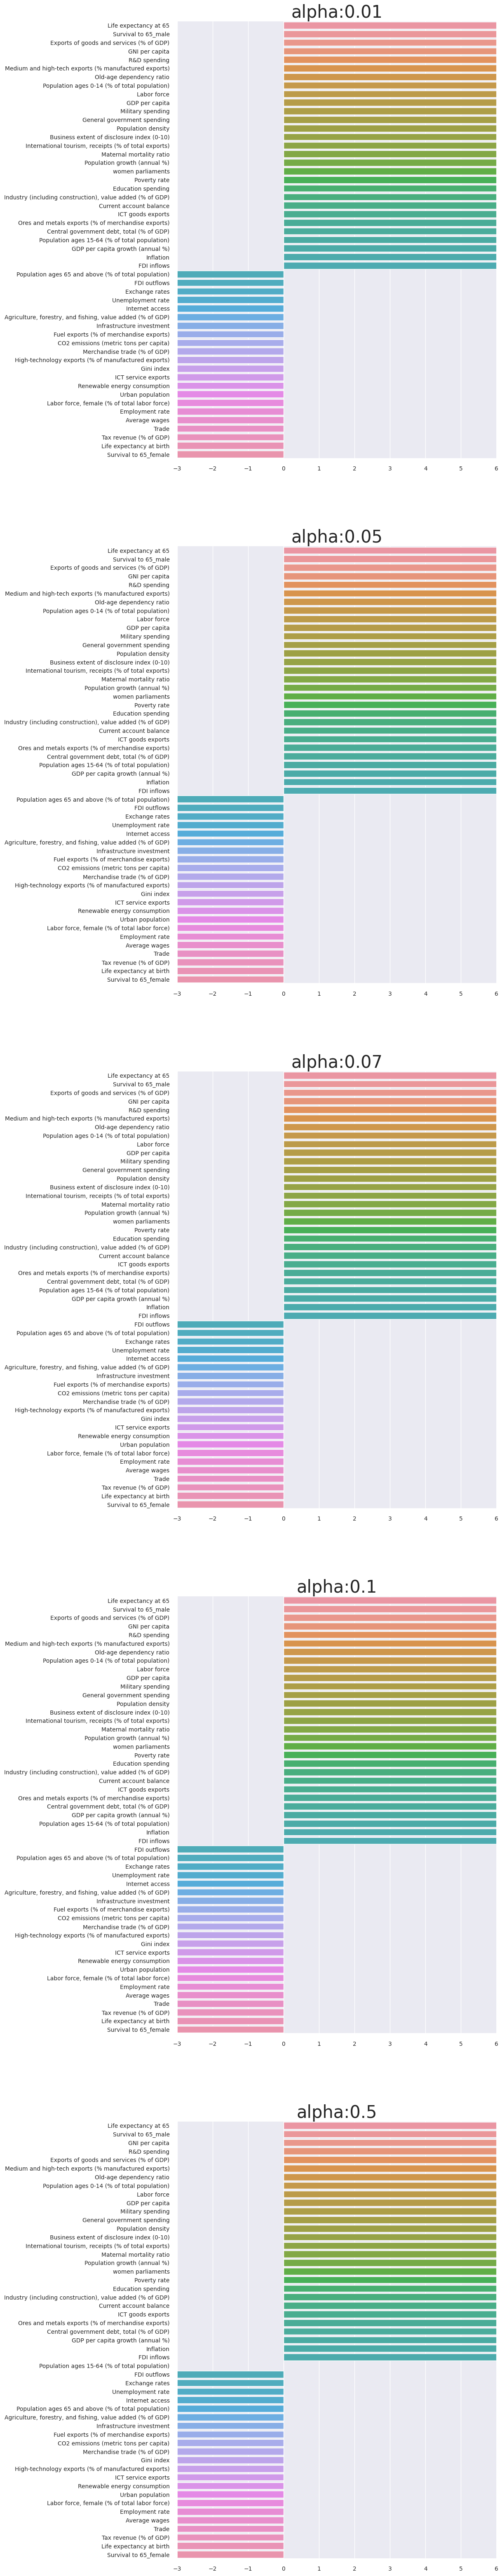

In [ ]:
alphas = [0.01, 0.05, 0.07, 0.1, 0.5]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=alphas, x_select_n = X_train, y_select_n= y_train)

# 반환된 coeff_lass_df를 첫 번째 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = 'alpha:'+str(alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

fig, axs = plt.subplots(figsize=(10, 80), nrows=5, ncols=1)

# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장.
for pos, alpha in enumerate(alphas) :
    lasso = Lasso(alpha = alpha)
    lasso.fit(X_train, y_train)
    # alpha에 따른 피처별로 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가
    coeff = pd.Series(data=lasso.coef_, index=X_train.columns)
    colname='alpha:'+str(alpha)
    coeff_df[colname] = coeff

    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3, 6)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

    axs[pos].tick_params(axis='x', labelsize=10)
    axs[pos].tick_params(axis='y', labelsize=10)

plt.show()

In [ ]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

feature_importance = lasso.coef_
feature_importance_df = pd.DataFrame({
    'attribute': X_train.columns,
    'lasso_coefficient': feature_importance
})

selected_features = feature_importance_df.sort_values(by='lasso_coefficient', ascending=False)
positive_features = selected_features[selected_features['lasso_coefficient'] > 0].nlargest(10, 'lasso_coefficient')
top_positive_features = positive_features.nlargest(20, 'lasso_coefficient')
print(top_positive_features)

                                            attribute  lasso_coefficient
28                              Life expectancy at 65        4837.211981
45                                Survival to 65_male        4456.076503
9            Exports of goods and services (% of GDP)        3430.969100
15                                     GNI per capita        3220.672452
42                                       R&D spending        3154.793695
31  Medium and high-tech exports (% manufactured e...        2937.959786
34                           Old-age dependency ratio        2875.100104
36       Population ages 0-14 (% of total population)        2764.030558
26                                        Labor force        2685.891459
13                                     GDP per capita        2470.759503


In [ ]:
top10_features = top_positive_features['attribute'].tolist()
evaluate_RFmodel(top10_features)
evaluate_LRmodel(top10_features)

<Random Forest Regressor 학습 성능>

MAE : 1054.022989
MSE : 4308489.860730
R2 : 0.939671


<Linear Regression 학습 성능>

MAE : 3576.475477
MSE : 27499759.831784
R2 : 0.614940


In [ ]:
top_positive_features = selected_features.nlargest(20, 'lasso_coefficient')
lasso_top20 = top_positive_features['attribute'].tolist()

### 2) Ridge

*   L2 규제 방식 > 불필요한 회귀 계수를 아예 0으로 > 무력화
*   특성이 많은데 그중 일부분만 중요하다면 라쏘가, 특성의 중요도가 전체적으로 비슷하다면 릿지가 좀 더 적합하다고 함

###### Ridge ######
alpha 0.01일 때 5 폴드 세트의 평균 RMSE: 8436.196
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 8379.965
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 8363.789
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 8274.941
alpha 1일 때 5 폴드 세트의 평균 RMSE: 8200.251
alpha 5일 때 5 폴드 세트의 평균 RMSE: 7747.875


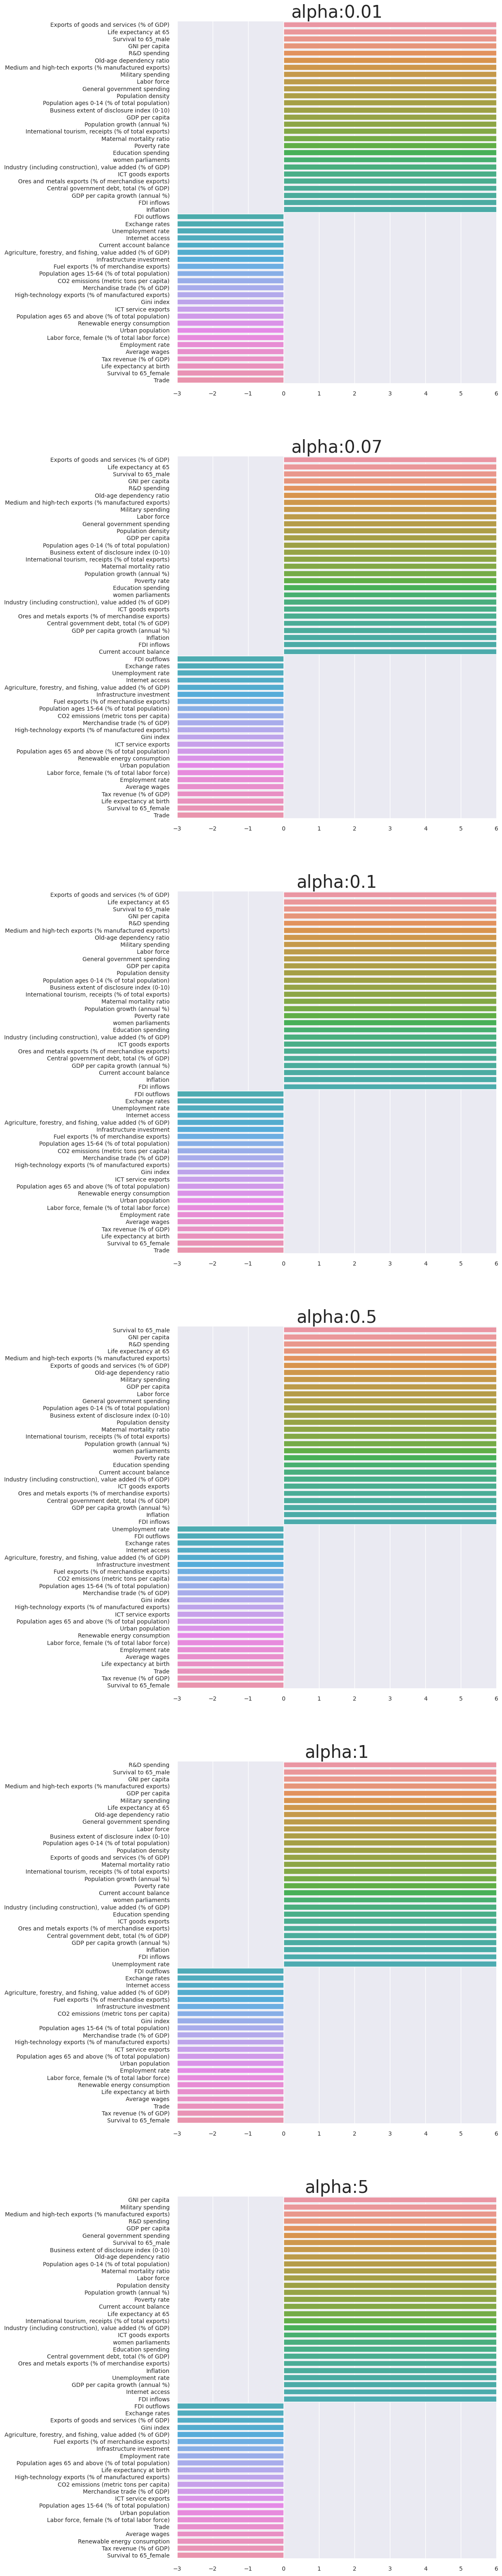

In [ ]:
alphas = [0.01, 0.07, 0.1, 0.5, 1, 5]
coeff_ridge_df = get_linear_reg_eval('Ridge', params=alphas, x_select_n = X_train, y_select_n= y_train)

sort_column = 'alpha:'+str(alphas[0])
coeff_ridge_df.sort_values(by=sort_column, ascending=False)

fig, axs = plt.subplots(figsize=(10, 80), nrows=6, ncols=1)
coeff_df = pd.DataFrame()

for pos, alpha in enumerate(alphas) :
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_train, y_train)
    coeff = pd.Series(data=ridge.coef_, index=X_train.columns)
    colname='alpha:'+str(alpha)
    coeff_df[colname] = coeff
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3, 6)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

    axs[pos].tick_params(axis='x', labelsize=10)
    axs[pos].tick_params(axis='y', labelsize=10)

plt.show()

In [ ]:
ridge = Ridge(alpha=0.01)
ridge.fit(X_train, y_train)

feature_importance = ridge.coef_
feature_importance_df = pd.DataFrame({
    'attribute': X_train.columns,
    'ridge_coefficient': feature_importance
})

selected_features = feature_importance_df.sort_values(by='ridge_coefficient', ascending=False)
positive_features = selected_features[selected_features['ridge_coefficient'] > 0].nlargest(10, 'ridge_coefficient')
top_positive_features = positive_features.nlargest(20, 'ridge_coefficient')
print(top_positive_features)

                                            attribute  ridge_coefficient
9            Exports of goods and services (% of GDP)       10806.331968
28                              Life expectancy at 65        4948.914047
45                                Survival to 65_male        4316.933466
15                                     GNI per capita        4291.266024
42                                       R&D spending        3138.801253
34                           Old-age dependency ratio        3000.635107
31  Medium and high-tech exports (% manufactured e...        2903.548439
33                                  Military spending        2497.267144
26                                        Labor force        2490.287512
16                        General government spending        2081.184583


In [ ]:
top10_features = top_positive_features['attribute'].tolist()
evaluate_RFmodel(top10_features)
evaluate_LRmodel(top10_features)

<Random Forest Regressor 학습 성능>

MAE : 1059.127317
MSE : 4218659.563685
R2 : 0.940929


<Linear Regression 학습 성능>

MAE : 3760.145881
MSE : 26122758.900124
R2 : 0.634221


In [ ]:
top_positive_features = selected_features.nlargest(20, 'ridge_coefficient')
ridge_top20 = top_positive_features['attribute'].tolist()

## 3) Elastic Net
*   Lasso와 Ridge의 결합

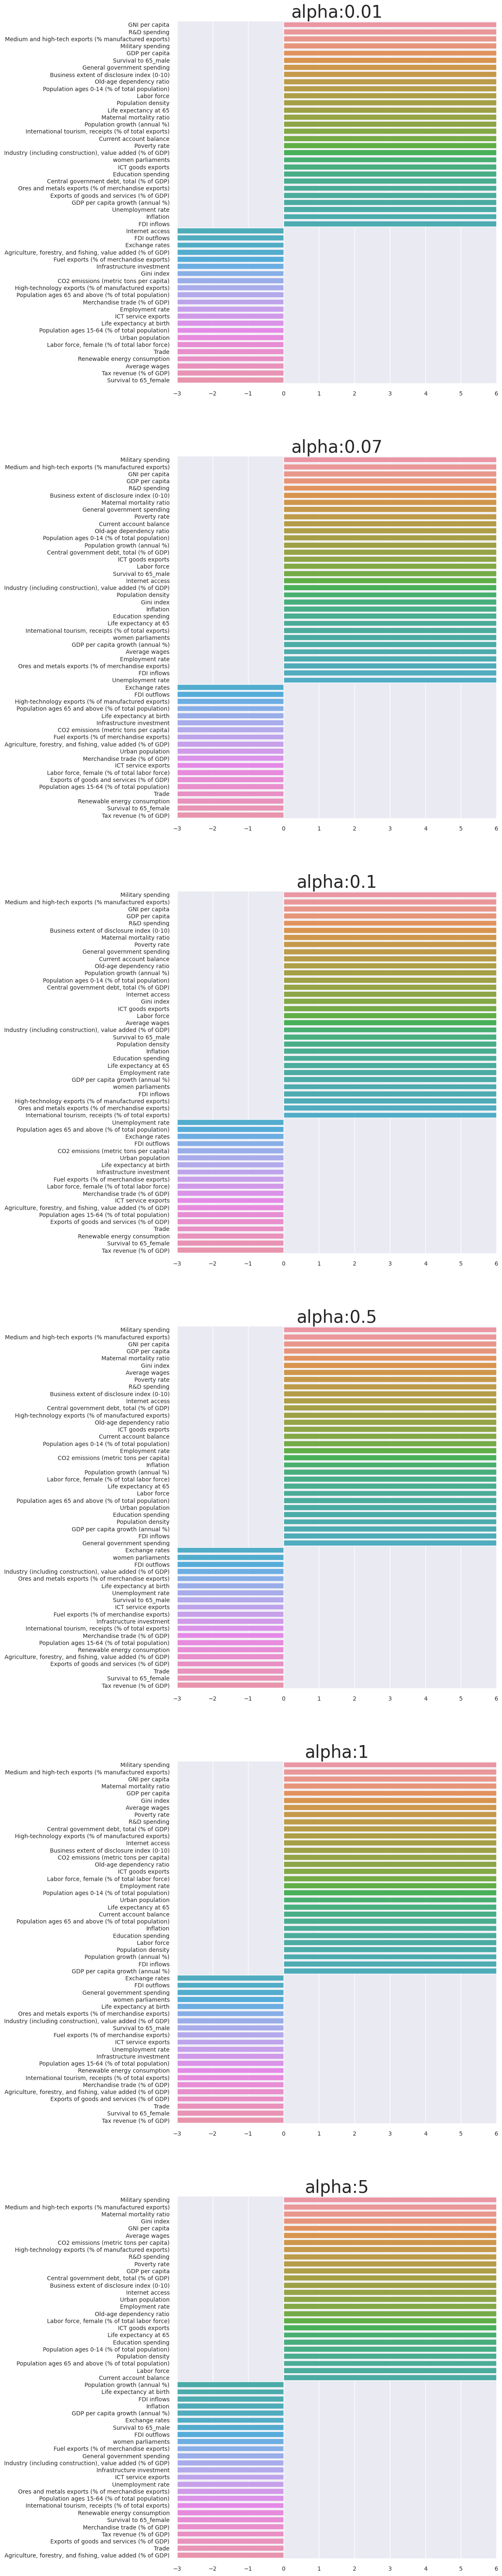

In [ ]:
from sklearn.linear_model import ElasticNet

alphas = [0.01, 0.07, 0.1, 0.5, 1, 5]

fig, axs = plt.subplots(figsize=(10, 80), nrows=6, ncols=1)

coeff_df = pd.DataFrame()

for pos, alpha in enumerate(alphas):
    elastic_net = ElasticNet(alpha=alpha)
    elastic_net.fit(X_train, y_train)

    coeff = pd.Series(data=elastic_net.coef_, index=X_train.columns)
    colname = 'alpha:' + str(alpha)
    coeff_df[colname] = coeff

    coeff_sorted = coeff.sort_values(ascending=False)

    sns.barplot(x=coeff_sorted.values, y=coeff_sorted.index, ax=axs[pos])

    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3, 6)

    axs[pos].tick_params(axis='x', labelsize=10)
    axs[pos].tick_params(axis='y', labelsize=10)

plt.show()

In [ ]:
elastic_net = ElasticNet(alpha=0.01)
elastic_net.fit(X_train, y_train)

feature_importance = elastic_net.coef_
feature_importance_df = pd.DataFrame({
    'attribute': X_train.columns,
    'elasticnet_coefficient': feature_importance
})

selected_features = feature_importance_df.sort_values(by='elasticnet_coefficient', ascending=False)
positive_features = selected_features[selected_features['elasticnet_coefficient'] > 0].nlargest(10, 'elasticnet_coefficient')
top_positive_features = positive_features.nlargest(10, 'elasticnet_coefficient')
print(top_positive_features)

                                            attribute  elasticnet_coefficient
15                                     GNI per capita             2800.587271
42                                       R&D spending             2686.828147
31  Medium and high-tech exports (% manufactured e...             2605.602577
33                                  Military spending             2517.225775
13                                     GDP per capita             2370.924766
45                                Survival to 65_male             2126.853791
16                        General government spending             1848.244206
2          Business extent of disclosure index (0-10)             1674.938665
34                           Old-age dependency ratio             1550.060842
36       Population ages 0-14 (% of total population)             1322.609908


In [ ]:
top10_features = top_positive_features['attribute'].tolist()
evaluate_RFmodel(top10_features)
evaluate_LRmodel(top10_features)

<Random Forest Regressor 학습 성능>

MAE : 1031.485289
MSE : 4077235.577714
R2 : 0.942909


<Linear Regression 학습 성능>

MAE : 3531.092704
MSE : 24782815.896941
R2 : 0.652984


In [ ]:
top_positive_features = selected_features.nlargest(20, 'elasticnet_coefficient')
elasticnet_top20 = top_positive_features['attribute'].tolist()